In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Time Series Forecasting using LSTM and GRU
In this notebook will use LSTM & GRU for predicting the price of stocks of Google for the year 2017

## Importing the libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

## Helper Functions for Plotting Predictions and Calculating RMSE

In [3]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Google Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Google Stock Price')
    plt.title('Google Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Google Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

## Getting the data

In [4]:
# First, we get the data
dataset = pd.read_csv('/content/drive/MyDrive/Week5/Datasets/GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


Slpitting dataset to train set (Before 2017) and test set (2017 and beyond)

In [5]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

Visualizing the data

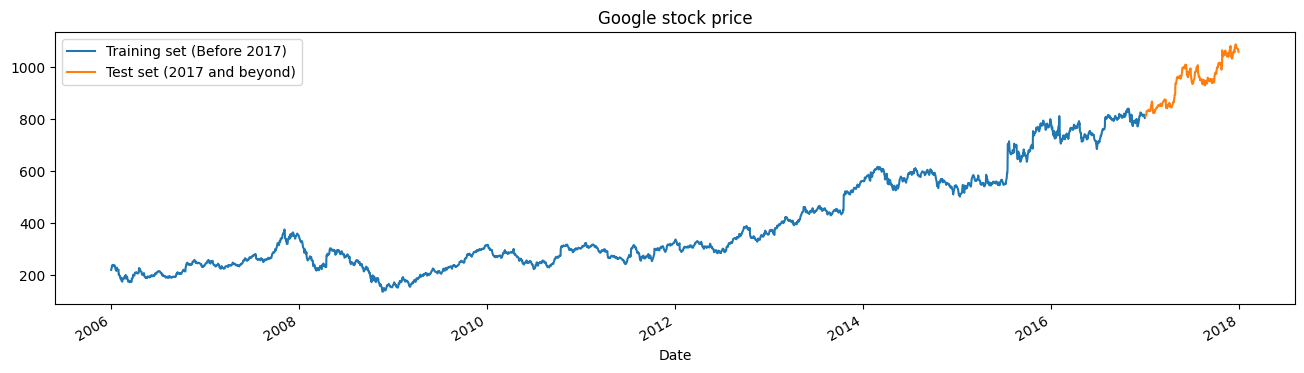

In [6]:
# We have chosen 'High' attribute for prices.
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('Google stock price')
plt.show()

## Data Preprocessing

Scaling the training set

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output. So for each element of training set, we have 60 previous training set elements

In [9]:
X_train = []
y_train = []
for i in range(60,2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

Reshaping X_train for efficient modelling

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

## LSTM Model

In [12]:
# The LSTM architecture
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=25,batch_size=32)

Epoch 1/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - loss: 0.0300
Epoch 2/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - loss: 0.0061
Epoch 3/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 0.0043
Epoch 4/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 0.0044
Epoch 5/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - loss: 0.0039
Epoch 6/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - loss: 0.0030
Epoch 7/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 0.0037
Epoch 8/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - loss: 0.0026
Epoch 9/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - loss: 0.0027
Epoch 10/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - loss: 0.0026
Epoch 11/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - loss: 0.0027
Epoch 12/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 0.0021
Epoch 13/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - loss: 0.0022
Epoch 14/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - loss: 0.0021
Epoch 15/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 


## Make preductuion with LSTM model

In [13]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [14]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step


Visualizing the results

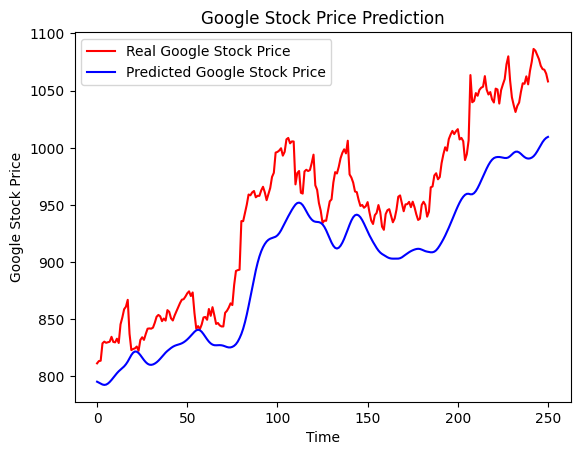

In [15]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

Evaluating LSMT Model

In [16]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 50.77542974526013.


## GRU Model

In [17]:
# The GRU architecture
regressorGRU = Sequential()

# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# The output layer
regressorGRU.add(Dense(units=1))

# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=25,batch_size=150)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 375ms/step - loss: 0.1035
Epoch 2/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step - loss: 0.0299
Epoch 3/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - loss: 0.0059
Epoch 4/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step - loss: 0.0034
Epoch 5/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - loss: 0.0028
Epoch 6/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - loss: 0.0027
Epoch 7/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - loss: 0.0029
Epoch 8/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 359ms/step - loss: 0.0025
Epoch 9/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - loss: 0.0026
Epoch 10/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - loss: 0.0027
Epoch 11/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step - loss: 0.0026
Epoch 12/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - loss: 0.0024
Epoch 13/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step - loss: 0.0020
Epoch 14/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - loss: 0.0024
Epoch 15/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - loss: 0.002


## Make preductuion with GRU model

In [18]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step


Visualizing the Results

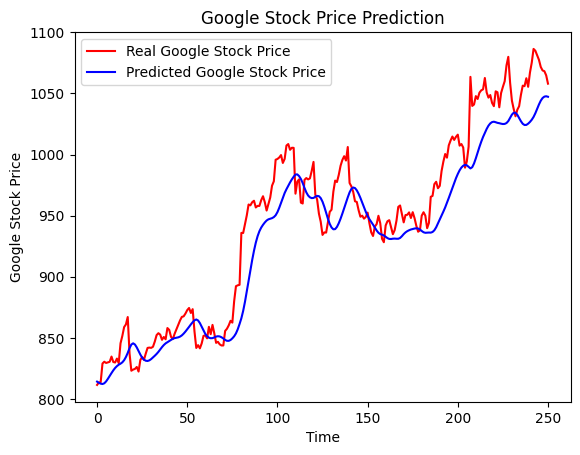

In [19]:
plot_predictions(test_set,GRU_predicted_stock_price)

Evaluating GRU Model

In [20]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 25.647369097168568.
